In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf

In [5]:
tf.enable_eager_execution()

In [6]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# 1. Make Data X_train, y_train, X_test, y_test

In [7]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [8]:
# make DeepMSpeptide format
tra = pd.read_csv('compareModel/2021MDPI_CapsNet/train.csv')
val = pd.read_csv('compareModel/2021MDPI_CapsNet/val.csv')
df_peptide_train = pd.concat([tra, val], axis=0).reset_index(drop=True)
df_peptide_test = pd.read_csv('compareModel/2021MDPI_CapsNet/test.csv')

inp = open(file_path+'detect_peptide_train_hpp.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_hpp.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_hpp.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_hpp.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train_hpp.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y_hpp.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_hpp.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y_hpp.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 668927 peptides and skipped 0
Loading input peptides
Succesfully loaded 133992 peptides and skipped 0
(535141, 81) (133786, 81) (133992, 81) (535141,) (133786,) (133992,)


# 2. train

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [10]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'
args = file_path + 'inputExample.txt'

print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

Loading model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________

In [11]:
model_2_1D.get_layer(index=0).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(23,50)).numpy()])
model_2_1D.get_layer(index=1).set_weights([])
model_2_1D.get_layer(index=2).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(3,50,128)).numpy(),
     np.zeros(128,)])
model_2_1D.get_layer(index=3).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(2,128,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=4).set_weights([])
model_2_1D.get_layer(index=5).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,64)).numpy(),
    np.zeros(64,)])
model_2_1D.get_layer(index=6).set_weights([])
model_2_1D.get_layer(index=7).set_weights([])
model_2_1D.get_layer(index=8).set_weights(
    [tf.keras.initializers.glorot_uniform(seed=7)(shape=(64,1)).numpy(),
    np.zeros(1,)])
model_2_1D.get_layer(index=9).set_weights([])

In [12]:
history = model_2_1D.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 535141 samples, validate on 133786 samples
Epoch 1/200
535141/535141 [==============================] - 80s 150us/sample - loss: 0.4772 - acc: 0.7769 - binary_crossentropy: 0.4772 - val_loss: 0.4452 - val_acc: 0.7951 - val_binary_crossentropy: 0.4452
Epoch 2/200
535141/535141 [==============================] - 80s 149us/sample - loss: 0.4444 - acc: 0.7967 - binary_crossentropy: 0.4444 - val_loss: 0.4354 - val_acc: 0.8003 - val_binary_crossentropy: 0.4354
Epoch 3/200
535141/535141 [==============================] - 79s 147us/sample - loss: 0.4364 - acc: 0.8014 - binary_crossentropy: 0.4364 - val_loss: 0.4463 - val_acc: 0.7936 - val_binary_crossentropy: 0.4463
Epoch 4/200
535141/535141 [==============================] - 78s 146us/sample - loss: 0.4321 - acc: 0.8038 - binary_crossentropy: 0.4321 - val_loss: 0.4275 - val_acc: 0.8065 - val_binary_crossentropy: 0.4275
Epoch 5/200
535141/535141 [==============================] - 77s 144us/sample - loss: 0.4291 - acc: 0.8055 - binary_

Epoch 40/200
535141/535141 [==============================] - 84s 158us/sample - loss: 0.4039 - acc: 0.8192 - binary_crossentropy: 0.4039 - val_loss: 0.4146 - val_acc: 0.8124 - val_binary_crossentropy: 0.4146
Epoch 41/200
535141/535141 [==============================] - 83s 154us/sample - loss: 0.4038 - acc: 0.8191 - binary_crossentropy: 0.4038 - val_loss: 0.4132 - val_acc: 0.8129 - val_binary_crossentropy: 0.4132
Epoch 42/200
535141/535141 [==============================] - 83s 155us/sample - loss: 0.4033 - acc: 0.8190 - binary_crossentropy: 0.4033 - val_loss: 0.4163 - val_acc: 0.8125 - val_binary_crossentropy: 0.4163
Epoch 43/200
535141/535141 [==============================] - 84s 157us/sample - loss: 0.4030 - acc: 0.8189 - binary_crossentropy: 0.4030 - val_loss: 0.4185 - val_acc: 0.8098 - val_binary_crossentropy: 0.4185
Epoch 44/200
535141/535141 [==============================] - 82s 153us/sample - loss: 0.4033 - acc: 0.8194 - binary_crossentropy: 0.4033 - val_loss: 0.4128 - val_a

535141/535141 [==============================] - 85s 158us/sample - loss: 0.3944 - acc: 0.8235 - binary_crossentropy: 0.3944 - val_loss: 0.4145 - val_acc: 0.8145 - val_binary_crossentropy: 0.4145
Epoch 119/200
535141/535141 [==============================] - 85s 159us/sample - loss: 0.3945 - acc: 0.8240 - binary_crossentropy: 0.3945 - val_loss: 0.4134 - val_acc: 0.8136 - val_binary_crossentropy: 0.4134
Epoch 120/200
535141/535141 [==============================] - 83s 156us/sample - loss: 0.3938 - acc: 0.8240 - binary_crossentropy: 0.3938 - val_loss: 0.4248 - val_acc: 0.8108 - val_binary_crossentropy: 0.4248
Epoch 121/200
535141/535141 [==============================] - 85s 159us/sample - loss: 0.3938 - acc: 0.8240 - binary_crossentropy: 0.3938 - val_loss: 0.4154 - val_acc: 0.8134 - val_binary_crossentropy: 0.4154
Epoch 122/200
535141/535141 [==============================] - 83s 154us/sample - loss: 0.3939 - acc: 0.8242 - binary_crossentropy: 0.3939 - val_loss: 0.4158 - val_acc: 0.813

535141/535141 [==============================] - 77s 144us/sample - loss: 0.3904 - acc: 0.8257 - binary_crossentropy: 0.3904 - val_loss: 0.4170 - val_acc: 0.8125 - val_binary_crossentropy: 0.4170
Epoch 197/200
535141/535141 [==============================] - 80s 150us/sample - loss: 0.3908 - acc: 0.8256 - binary_crossentropy: 0.3908 - val_loss: 0.4228 - val_acc: 0.8107 - val_binary_crossentropy: 0.4228
Epoch 198/200
535141/535141 [==============================] - 78s 145us/sample - loss: 0.3903 - acc: 0.8256 - binary_crossentropy: 0.3903 - val_loss: 0.4172 - val_acc: 0.8139 - val_binary_crossentropy: 0.4172
Epoch 199/200
535141/535141 [==============================] - 78s 145us/sample - loss: 0.3912 - acc: 0.8259 - binary_crossentropy: 0.3912 - val_loss: 0.4228 - val_acc: 0.8114 - val_binary_crossentropy: 0.4228
Epoch 200/200
535141/535141 [==============================] - 78s 146us/sample - loss: 0.3908 - acc: 0.8256 - binary_crossentropy: 0.3908 - val_loss: 0.4248 - val_acc: 0.812

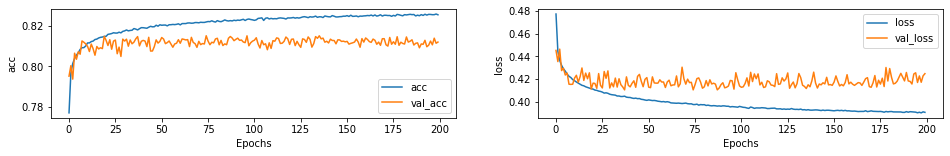

In [13]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

133992/133992 [==============================] - 12s 88us/sample - loss: 0.4086 - acc: 0.8211 - binary_crossentropy: 0.4086
Test Accuracy: [0.40855041332754194, 0.82106394, 0.40855068]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     66996
           1       0.80      0.86      0.83     66996

    accuracy                           0.82    133992
   macro avg       0.82      0.82      0.82    133992
weighted avg       0.82      0.82      0.82    133992

rf auc : 0.8984298998778026


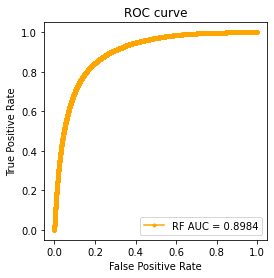

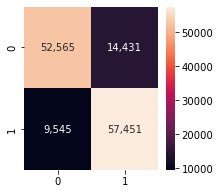

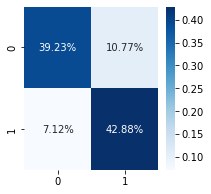

In [14]:
test_acc = model_2_1D.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [15]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_2_1D.save("compareModel/2019Bioinformatics_DeepMSPeptide/2021KSBi_DeepMSpeptide.h5")

# It can be used to reconstruct the model identically.
# model_2_1D_re = keras.models.load_model("compareModel/2019Bioinformatics_DeepMSPeptide/2021KSBi_DeepMSpeptide.h5")

In [38]:
pe1 = pd.read_csv('compareModel/2021MDPI_CapsNet/pe1.csv')
dmp = pd.read_csv('compareModel/2021MDPI_CapsNet/dmp.csv')
mp = pd.read_csv('compareModel/2021MDPI_CapsNet/mp.csv')

In [41]:
pe1.head(1)

,PEP,Class
0,ATLEVSSIIK,PE1


In [43]:
pe1.rename({'PEP':'Seqs', 'Class':'Label'}, axis=1, inplace=True)
dmp.rename({'PEP':'Seqs', 'Class':'Label'}, axis=1, inplace=True)
mp.rename({'PEP':'Seqs', 'Class':'Label'}, axis=1, inplace=True)

In [44]:
print(pe1.shape, dmp.shape, mp.shape)

(8244, 2) (8177, 2) (5101, 2)


In [47]:
pe1['Label']=1
dmp['Label']=1
mp['Label']=0

In [48]:
# make DeepMSpeptide format
inp = open(file_path+'HPP_pe1.txt', 'w')
inp_y = open(file_path+'HPP_pe1_y.txt', 'w')
for x, y in pe1[['Seqs', 'Label']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'HPP_dmp.txt', 'w')
inp_y = open(file_path+'HPP_dmp_y.txt', 'w')
for x, y in dmp[['Seqs', 'Label']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'HPP_mp.txt', 'w')
inp_y = open(file_path+'HPP_mp_y.txt', 'w')
for x, y in mp[['Seqs', 'Label']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'HPP_pe1.txt'
print('Loading input peptides')
X_pe1, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'HPP_pe1_y.txt')
y_pe1 = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'HPP_dmp.txt'
print('Loading input peptides')
X_dmp, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'HPP_dmp_y.txt')
y_dmp = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'HPP_mp.txt'
print('Loading input peptides')
X_mp, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'HPP_mp_y.txt')
y_mp = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

Loading input peptides
Succesfully loaded 8244 peptides and skipped 0
Loading input peptides
Succesfully loaded 8177 peptides and skipped 0
Loading input peptides
Succesfully loaded 5101 peptides and skipped 0


In [49]:
y_pe1_pred = [i[0] for i in model_2_1D.predict(X_pe1)]

y_dmp_pred = [i[0] for i in model_2_1D.predict(X_dmp)]
y_mp_pred = [i[0] for i in model_2_1D.predict(X_mp)]

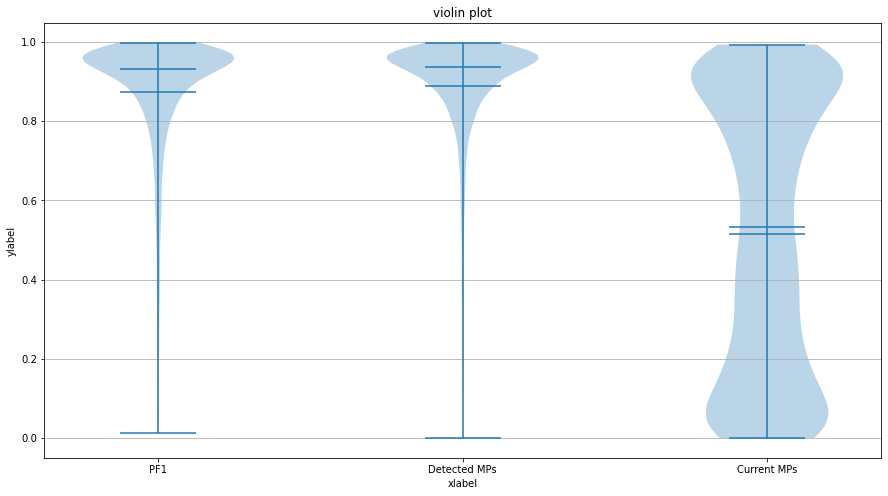

In [51]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(15, 8))

#all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]
#
# print(y_pe1_pred)
axes.violinplot([y_pe1_pred,y_dmp_pred,y_mp_pred],
                   showmeans=True,
                   showmedians=True
                   )

axes.set_title('violin plot')

# adding horizontal grid lines

axes.yaxis.grid(True)
#axes.set_xticks([y + 1 for y in range(len(all_data))], )
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')

plt.setp(axes, xticks=[y + 1 for y in range(len([y_pe1_pred,y_dmp_pred,y_mp_pred]))],
         xticklabels=['PF1', 'Detected MPs', 'Current MPs'],
         )

plt.show()

In [52]:
df_pe1 = pd.DataFrame([['PE1', _] for _ in y_pe1_pred],
                     columns=['class', 'prob'])
df_dmp = pd.DataFrame([['Detected_MPs', _] for _ in y_dmp_pred],
                     columns=['class', 'prob'])
df_mp = pd.DataFrame([['MPs', _] for _ in y_mp_pred],
                     columns=['class', 'prob'])
df_sns = pd.concat([df_pe1, df_dmp, df_mp], axis=0).reset_index(drop=True)

In [53]:
import seaborn as sns

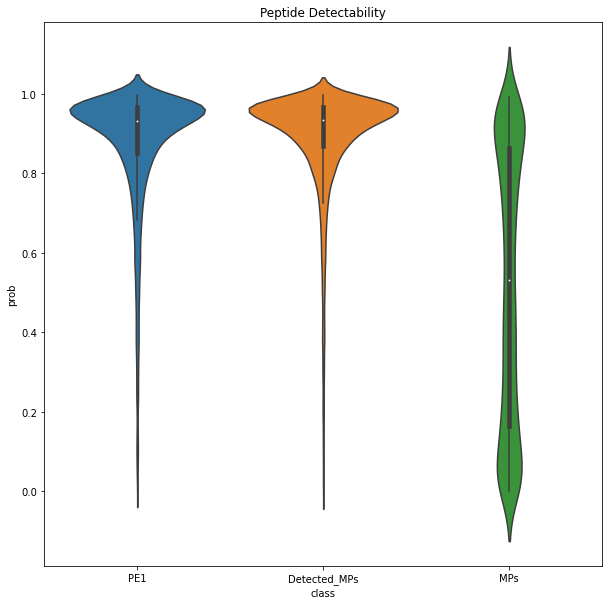

In [54]:
plt.figure(figsize=(10,10))
plt.title('Peptide Detectability')
plt.ylabel('Detectability')
plt.xlabel('Type')

sns.violinplot(data=df_sns, x='class', y='prob', order=['PE1', 'Detected_MPs', 'MPs'])
plt.show()

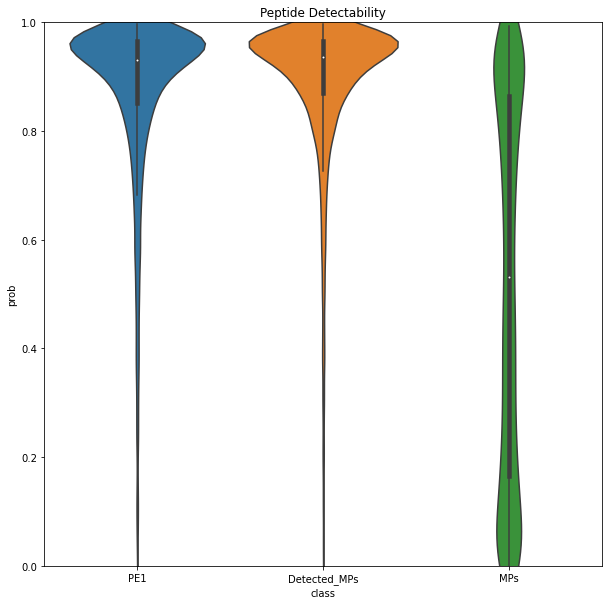

In [55]:
plt.figure(figsize=(10,10))
plt.title('Peptide Detectability')
plt.ylabel('Detectability')
plt.xlabel('Type')

plt.ylim(0, 1)
sns.violinplot(data=df_sns, x='class', y='prob', order=['PE1', 'Detected_MPs', 'MPs'])
plt.show()